## About Dataset
### Context
This is image data of Natural Scenes around the world.

### Content
This Data contains around 25k images of size 150x150 distributed under 6 categories.
{'buildings' -> 0,
'forest' -> 1,
'glacier' -> 2,
'mountain' -> 3,
'sea' -> 4,
'street' -> 5 }

The Train, Test and Prediction data is separated in each zip files. There are around 14k images in Train, 3k in Test and 7k in Prediction.
This data was initially published on https://datahack.analyticsvidhya.com by Intel to host a Image classification Challenge.

# Data Loading and Preprocessing

### Downloading the Dataset

In [1]:
import os
import shutil
import kagglehub

In [2]:
# Function to download the data at a specific location
def download_dataset(url, data_path):

    # First checking whetherthe data exists or not
    if os.path.exists("Data"):
        print(f"Dataset already exists at the path: {data_path}")

    else:
        path = kagglehub.dataset_download(url)
        shutil.move(path, data_path)
        print(f"Data is saved in the path: {data_path}")

# Parameters
url = "puneet6060/intel-image-classification"
data_path = "./Data/"

In [3]:
download_dataset(url, data_path)

Dataset already exists at the path: ./Data/


Making the paths for the train and test dataset.

In [4]:
train_data = os.path.join("Data", "seg_train", "seg_train")
test_data = os.path.join("Data", "seg_test", "seg_test")

In [5]:
os.listdir(train_data)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [6]:
os.listdir(test_data)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

Taking an image example.

In [7]:
forest_data = os.path.join(train_data, "forest")
forest_img = os.path.join(forest_data, os.listdir(forest_data)[0])

In [8]:
print(forest_img)

Data\seg_train\seg_train\forest\10007.jpg


# Checking the shape of the images

In [9]:
from tensorflow.keras.preprocessing import image
import numpy as np

In [10]:
# Load image and convert to array
img = image.load_img(forest_img)
img_array = image.img_to_array(img)

# Print shape
print("Image Shape:", img_array.shape)

Image Shape: (150, 150, 3)


# Loading and Augmenting data

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
# Augmenting the train dataset
train_datagen = ImageDataGenerator(
    rescale = 1.0/255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = "nearest"   
)

# Augmenting the test dataset
test_datagen = ImageDataGenerator(
    rescale = 1.0/255
)

In [13]:
train_generator = train_datagen.flow_from_directory(
    # Path to the training dataset
    train_data,

    # Setting the shape of the images
    target_size = (150, 150),

    batch_size = 32,

    class_mode = "categorical"
)

val_generator = test_datagen.flow_from_directory(
    # Path to the test dataset
    test_data,

    # Setting the shape of the test images same as training
    target_size = (150, 150),

    batch_size = 32,

    class_mode = "categorical",

    shuffle = False
)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [14]:
import matplotlib.pyplot as plt

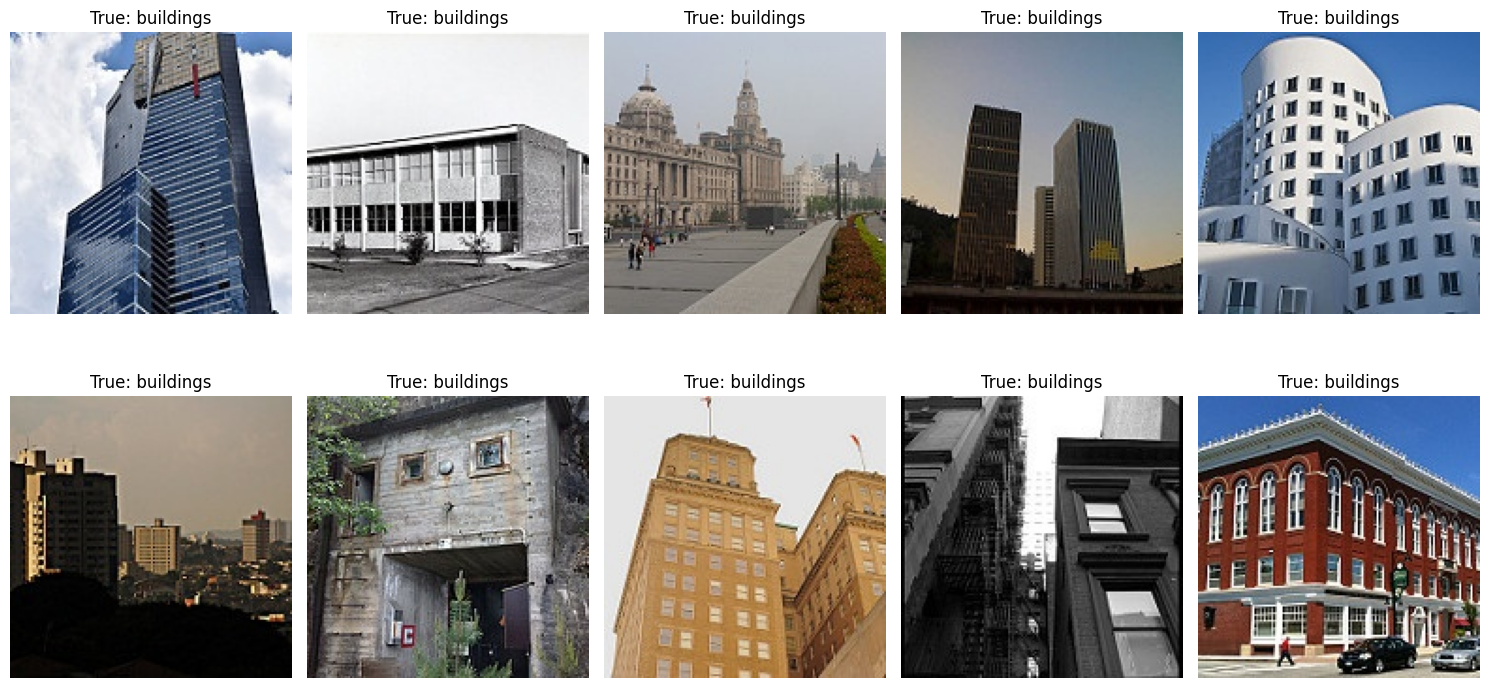

In [15]:
# Get class names
class_names = list(val_generator.class_indices.keys())

plt.figure(figsize = (15, 8))

# Display first 10 images from the generator
for i in range(10):

    img, label = val_generator.next()
    
    plt.subplot(2, 5, i + 1)
    plt.imshow(img[0])
    true_label = class_names[np.argmax(label[0])]
    plt.title(f"True: {true_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Model Building

Creating a Convolutoinal Neural Network using TensorFlow's functional API.

In [16]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model

In [17]:
# Creating a Model Class
class ClassificationModel(Model):
    def __init__(self, num_classes = 6, num_blocks = 3, base_filter = 64, filter_multiplier = 2):
        super(ClassificationModel, self).__init__()
        self.num_blocks = num_blocks
        self.conv_blocks = []

        # Creating blocks with increasing filters
        for i in range(num_blocks):
            filters = base_filter * (filter_multiplier ** i)

            self.conv_blocks.append([
                Conv2D(filters, (3, 3), activation = "relu", padding = "same"),
                MaxPooling2D((2, 2))
            ])

        self.flatten = Flatten()
        self.fc1 = Dense(128, activation = "relu")
        self.dropout = Dropout(0.3)
        self.output_layer = Dense(num_classes, activation = "sigmoid" if num_classes == 1 else "softmax")

    def call(self, inputs):
        x = inputs
        for conv_layer, pool_layer in self.conv_blocks:
            x = conv_layer(x)
            x = pool_layer(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x)
        return self.output_layer(x)

# Model Training

In [18]:
# Initiating the model with 3 Convolution layers
model = ClassificationModel(num_classes = 6, num_blocks = 3, base_filter = 64, filter_multiplier = 2)

In [19]:
# BUilding the model
model.build(input_shape = (None, 150, 150, 3))

In [20]:
# Model Summary
model.summary()

Model: "classification_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  1792      
                                                                 
 max_pooling2d (MaxPooling2  multiple                  0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           multiple                  73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  multiple                  0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           multiple                  295168    
                                                                 
 max_pooling2d_2 (MaxPoolin  multiple         

Training the model with Adam Optimizer.

In [21]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer = Adam(learning_rate = 0.001), loss = "categorical_crossentropy", metrics = ["accuracy"])

In [22]:
# Training the model with 10 epochs
history = model.fit(
    train_generator,
    validation_data = val_generator,
    epochs = 10,
    batch_size = 32
)

Epoch 1/10

439/439 [==============================] - 192s 435ms/step - loss: 1.1442 - accuracy: 0.5490 - val_loss: 0.8747 - val_accuracy: 0.6663
Epoch 2/10
439/439 [==============================] - 189s 431ms/step - loss: 0.8644 - accuracy: 0.6729 - val_loss: 0.5934 - val_accuracy: 0.7897
Epoch 3/10
439/439 [==============================] - 192s 437ms/step - loss: 0.7437 - accuracy: 0.7300 - val_loss: 0.5757 - val_accuracy: 0.8023
Epoch 4/10
439/439 [==============================] - 193s 439ms/step - loss: 0.6878 - accuracy: 0.7548 - val_loss: 0.5390 - val_accuracy: 0.8087
Epoch 5/10
439/439 [==============================] - 188s 427ms/step - loss: 0.6445 - accuracy: 0.7656 - val_loss: 0.5627 - val_accuracy: 0.8040
Epoch 6/10
439/439 [==============================] - 188s 427ms/step - loss: 0.6288 - accuracy: 0.7735 - val_loss: 0.5184 - val_accuracy: 0.8173
Epoch 7/10
439/439 [==============================] - 187s 426ms/step - loss: 0.5948 - accuracy: 0.7867 - val_loss: 0.4597 

### Plotting the Accuracy and Loss

Function to plot the `loss` and `accuracy` of the model.

In [23]:
def plot_history(history, type = None):
    plt.figure(figsize=(8, 5))

    if type == "Loss":
        plt.plot(history.history["loss"], label = "Training Loss")
        if "val_loss" in history.history:
            plt.plot(history.history["val_loss"], label = "Validation Loss")
        plt.title("Loss over epochs")
        plt.ylabel("Loss")

    elif type == "Accuracy":
        plt.plot(history.history["accuracy"], label = "Training Accuracy")
        if "val_accuracy" in history.history:
            plt.plot(history.history["val_accuracy"], label = "Validation Accuracy")
        plt.title("Accuracy over epochs")
        plt.ylabel("Accuracy")

    else:
        print("type should be either \"Loss\" or \"Accuracy\"")
        return

    plt.xlabel("Epoch")
    plt.legend()
    plt.grid(True)
    plt.show()

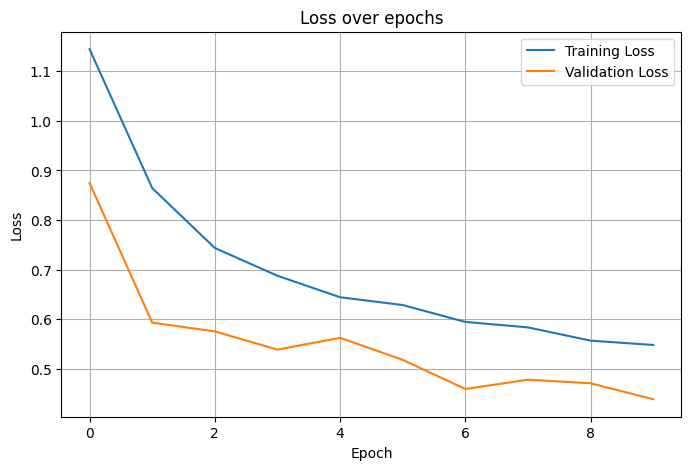

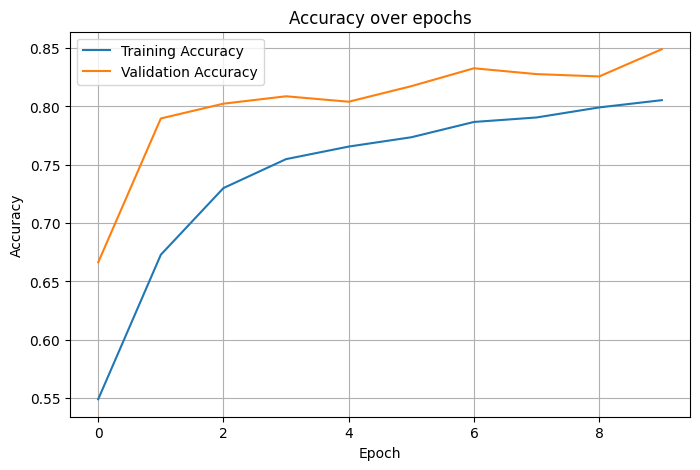

In [24]:
# Plotting both Loss and Accuracy
plot_history(history, type = "Loss")
plot_history(history, type = "Accuracy")

# Model Evaluation

In [25]:
# Evaluating model on the Test Dataset
loss, accuracy = model.evaluate(val_generator, verbose = 1)
print(f"Test Loss = {loss:.4f}")
print(f"Test Accuracy = {accuracy:.4f}")

94/94 [==============================] - 9s 96ms/step - loss: 0.4391 - accuracy: 0.8490
Test Loss = 0.4391
Test Accuracy = 0.8490


Calculating Precision, Recall, F-1, Accuracy of the model. 

In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np

Functions to calculte different metrics.

In [27]:
def calculate_accuracy(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

def calculate_precision(y_true, y_pred):
    return precision_score(y_true, y_pred, average = "weighted")

def calculate_recall(y_true, y_pred):
    return recall_score(y_true, y_pred, average = "weighted")

def calculate_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average = "weighted")

In [28]:
# Predict on test data
y_pred_probs = model.predict(val_generator)
y_pred = np.argmax(y_pred_probs, axis = 1)
y_true = val_generator.classes

print("-"*100)

# Metrics
print("Accuracy:", calculate_accuracy(y_true, y_pred))
print("Precision:", calculate_precision(y_true, y_pred))
print("Recall:", calculate_recall(y_true, y_pred))
print("F1-Score:", calculate_f1(y_true, y_pred))

94/94 [==============================] - 9s 96ms/step
----------------------------------------------------------------------------------------------------
Accuracy: 0.849
Precision: 0.8520986093410526
Recall: 0.849
F1-Score: 0.8491488160234261


Confusion Matrix

In [29]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [30]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Get class labels
class_names = list(val_generator.class_indices.keys())

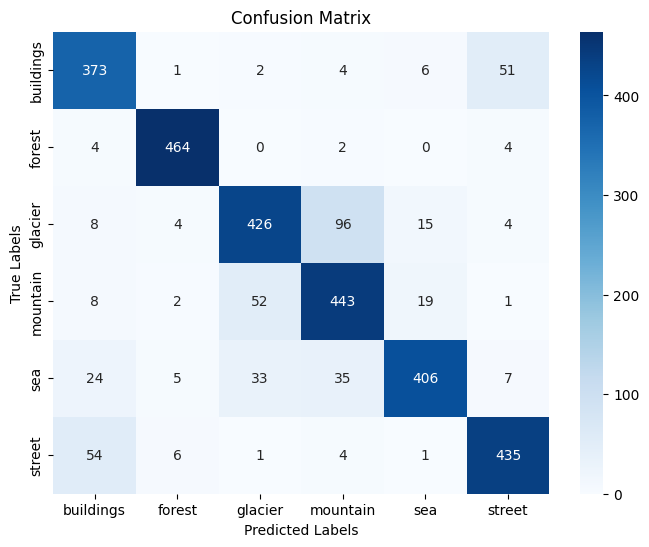

In [31]:
# Plotting
plt.figure(figsize = (8,6))
sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", xticklabels = class_names, yticklabels = class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


# Visualization and Interpretation

1.	Display a few misclassified images with the actual and predicted labels

In [34]:
import pandas as pd

In [43]:
# Initialize a list to store the data
data = []

for i in range(len(y_true)):
    # Get the image name
    img_name = val_generator.filenames[i]
    
    # Get the true label
    true_label = class_names[y_true[i]]
    
    # Get the predicted label
    pred_label = class_names[y_pred[i]]
    
    # Append the image name, true label, and predicted label to the list
    data.append([img_name, true_label, pred_label])

In [45]:
dataset = pd.DataFrame(data, columns=["Image_Name", "True_Label", "Predicted_Label"])

misclassified_dataset = dataset[dataset["True_Label"] != dataset["Predicted_Label"]]

In [46]:
misclassified_dataset.head()

,Image_Name,True_Label,Predicted_Label
5,buildings\20074.jpg,buildings,mountain
22,buildings\20246.jpg,buildings,street
25,buildings\20294.jpg,buildings,street
29,buildings\20366.jpg,buildings,street
31,buildings\20390.jpg,buildings,street


In [57]:
from PIL import Image

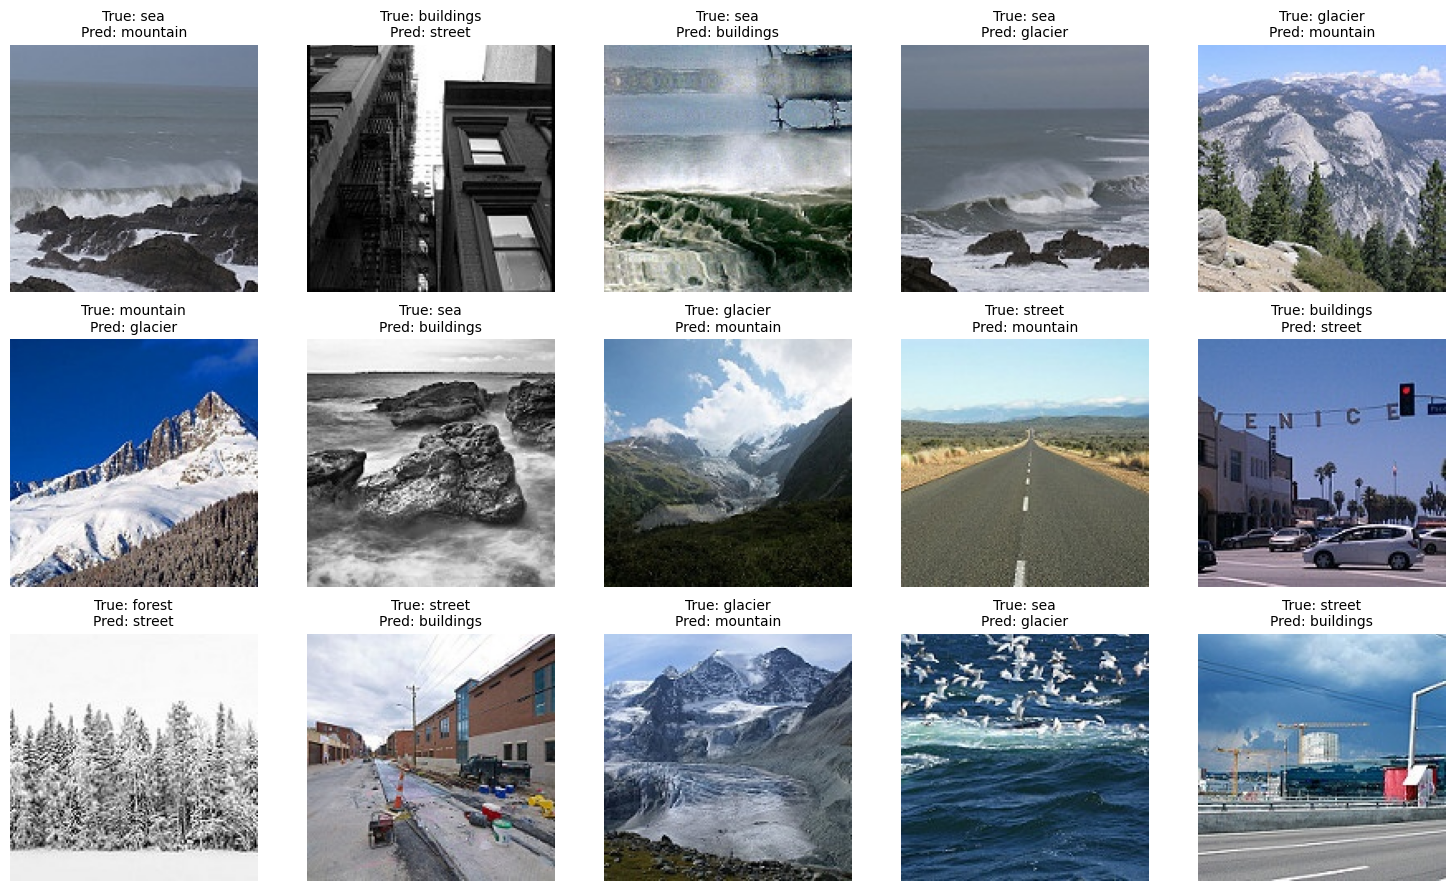

In [59]:
image_directory = test_data

# Set up the plot grid
fig, axes = plt.subplots(nrows = 3, ncols = 5, figsize = (15, 9))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Randomly sample 15 misclassified images
random_sample = misclassified_dataset.sample(n = 15, random_state = 42)

for i, (index, row) in enumerate(random_sample.iterrows()):

    # Load the image using PIL
    img_path = os.path.join(image_directory, row["Image_Name"])
    img = Image.open(img_path)
    
    # Plot the image
    axes[i].imshow(img)
    axes[i].axis("off")
    
    axes[i].set_title(f"True: {row['True_Label']}\nPred: {row['Predicted_Label']}", fontsize = 10)

plt.tight_layout()
plt.show()


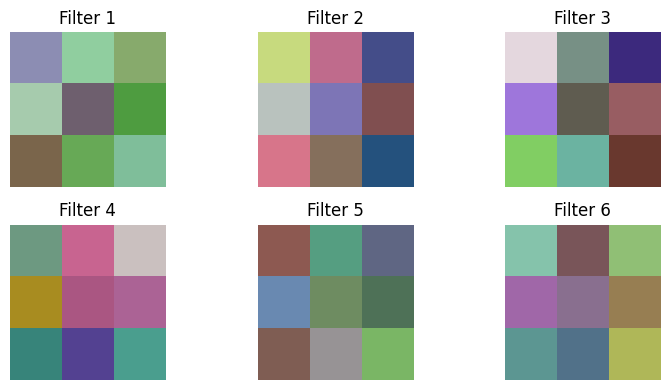

In [ ]:
# First CNN layer
conv_layer = model.layers[0]

# Weights of the layer
filters, biases = conv_layer.get_weights()

# Normalize filter values
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# Number of filters to display
n_filters = 6
nrows = 2
ncols = n_filters // nrows

# Set up the plot
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (8, 4))

axes = axes.flatten()

# Loop through the filters and display them
for i in range(n_filters):
    f = filters[:, :, :, i]
    
    # Plot the filter
    ax = axes[i]
    ax.imshow(f)
    ax.set_title(f"Filter {i+1}")
    ax.axis("off")

plt.tight_layout()
plt.show()


- **Accuracy**: 84.9% – This indicates that 84.9% of the model's predictions are correct. While this is a strong result, there's room for improvement, especially if the goal is to achieve near-perfect performance or to handle more complex data.

- **Precision**: 85.2% – This shows that when the model predicts a positive class, it is correct 85.2% of the time. A higher precision value is generally better, but balancing it with recall is important.

- **Recall**: 84.9% – This indicates that 84.9% of the actual positives were correctly identified by the model. Recall focuses on how well the model detects all relevant instances of a class, so this value is strong, but it can be improved in cases where false negatives are critical.

- **F1-Score**: 84.9% – The F1-Score is a harmonic mean of precision and recall, showing a balance between both. A score of 0.849 suggests the model is relatively well-balanced, but improvement is still possible.